<a href="https://colab.research.google.com/github/AlySerry0/CSEN903-Airline-Team-133/blob/main/Airline_133.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DATA FETCHING

In [1]:
!git clone https://github.com/AlySerry0/CSEN903-Airline-RawData.git

raw_data_dir = '/content/CSEN903-Airline-RawData'

Cloning into 'CSEN903-Airline-RawData'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 3.42 MiB | 2.84 MiB/s, done.


In [2]:
!pip install vaderSentiment shap lime tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 16.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 8.3 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9f94b1a728d0b9b0c702f83eddfc61b0205eca6082682fe61c08efa859e2e208
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

import shap
import lime
import lime.lime_tabular

In [4]:
AirlineScrappedReview = pd.read_csv(f'{raw_data_dir}/AirlineScrappedReview_Cleaned.csv')
Customer_comment = pd.read_csv(f'{raw_data_dir}/Customer_comment.csv')
Passanger_Booking_Data = pd.read_csv(f'{raw_data_dir}/Passanger_booking_data.csv')
Survey_Data_Inflight_Satisfaction_Score = pd.read_csv(f'{raw_data_dir}/Survey data_Inflight Satisfaction Score.csv')

DATA CLEANING

In [5]:
AirlineScrappedReview.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3575 entries, 0 to 3574
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Passanger_Name   3574 non-null   object 
 1   Flying_Date      955 non-null    object 
 2   Route            2809 non-null   object 
 3   Rating           3575 non-null   int64  
 4   Verified         3575 non-null   object 
 5   Review_title     3575 non-null   object 
 6   Review_content   3575 non-null   object 
 7   Traveller_Type   3575 non-null   object 
 8   Class            3575 non-null   object 
 9   Start_Location   2809 non-null   object 
 10  End_Location     2809 non-null   object 
 11  Layover_Route    484 non-null    object 
 12  Start_Latitude   3515 non-null   float64
 13  Start_Longitude  3515 non-null   float64
 14  Start_Address    3515 non-null   object 
 15  End_Latitude     3476 non-null   float64
 16  End_Longitude    3476 non-null   float64
 17  End_Address   

In [6]:
AirlineScrappedReview.head()

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,Paige Boet,June 2023,New Orleans to London,1,Trip Verified,The airline lost my luggage,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,NaN,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,S Layne,March 2023,London to Amman,1,Trip Verified,fully refunded by our travel insurance,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,NaN,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,E Lanewoski,NaN,Heathrow to Bodrum,2,Trip Verified,no boarding drinks provided,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,NaN,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Joel Burman,June 2023,Amman to London,4,Not Verified,WiFi didn't work,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,NaN,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,R Vines,NaN,London City to Ibiza,7,Trip Verified,stick with economy,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,NaN,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


In [7]:
AirlineScrappedReview.isnull().sum()

,0
Passanger_Name,1
Flying_Date,2620
Route,766
Rating,0
Verified,0
Review_title,0
Review_content,0
Traveller_Type,0
Class,0
Start_Location,766


In [8]:
AirlineScrappedReview.describe(include='all')

,Passanger_Name,Flying_Date,Route,Rating,Verified,Review_title,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
count,3574,955,2809,3575.000000,3575,3575,3575,3575,3575,2809,2809,484,3515.000000,3515.000000,3515,3476.000000,3476.000000,3476
unique,2759,100,1541,NaN,2,2570,3501,6,5,332,411,50,NaN,NaN,284,NaN,NaN,320
top,David Ellis,August 2015,London to Johannesburg,NaN,Not Verified,British Airways customer review,SFO-LHR-SFO in Premium Economy in December 201...,Couple Leisure,Economy Class,London Heathrow,London Heathrow,London,NaN,NaN,"Nanno, Ville d'Anaunia, Comunità della Val di ...",NaN,NaN,"Nanno, Ville d'Anaunia, Comunità della Val di ..."
freq,44,25,16,NaN,2508,947,2,949,1846,583,437,197,NaN,NaN,766,NaN,NaN,766
mean,NaN,NaN,NaN,4.790490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.639473,-2.164986,NaN,40.550399,-1.118816,NaN
std,NaN,NaN,NaN,3.170323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.022014,44.576587,NaN,18.723619,46.045735,NaN
min,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-37.666951,-123.182909,NaN,-37.814245,-123.179234,NaN
25%,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.893320,-0.458780,NaN,39.739236,-0.458780,NaN
50%,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.314475,-0.127765,NaN,46.314475,-0.127765,NaN
75%,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.467739,11.048029,NaN,51.467739,11.048029,NaN


In [9]:
columns_to_drop = [
    'Flying_Date',        # Too many missing values
    'Passanger_Name', 'Review_title',     # Unneeded identifiers
]

AirlineScrappedReview['Layover_Route'] = AirlineScrappedReview['Layover_Route'].fillna("None")
AirlineScrappedReview = AirlineScrappedReview.drop(columns=columns_to_drop)
AirlineScrappedReview = AirlineScrappedReview.replace('Unknown', np.nan)
AirlineScrappedReview = AirlineScrappedReview.dropna()
AirlineScrappedReview = AirlineScrappedReview.drop_duplicates()

In [10]:
# Display the final prepped DataFrame
print("\n--- Final Prepped DataFrame ---")
AirlineScrappedReview.head()


--- Final Prepped DataFrame ---


,Route,Rating,Verified,Review_content,Traveller_Type,Class,Start_Location,End_Location,Layover_Route,Start_Latitude,Start_Longitude,Start_Address,End_Latitude,End_Longitude,End_Address
0,New Orleans to London,1,Trip Verified,The airline lost my luggage and was absolutely...,Solo Leisure,Economy Class,New Orleans,London,None,29.975998,-90.078213,"New Orleans, Orleans Parish, Louisiana, United...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
1,London to Amman,1,Trip Verified,"We booked on the BA website, round trip flight...",Couple Leisure,Business Class,London,Amman,None,51.507446,-0.127765,"London, Greater London, England, United Kingdom",31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,..."
2,Heathrow to Bodrum,2,Trip Verified,"First time flying with BA business class, neve...",Solo Leisure,Business Class,London Heathrow,Bodrum,None,51.467739,-0.458780,"London Heathrow Airport, The Beacon Roundabout...",37.034399,27.430651,"Bodrum, Muğla, Ege Bölgesi, Türkiye"
3,Amman to London,4,Not Verified,You can buy sandwiches and crisps but don't ex...,Solo Leisure,Economy Class,Amman,London,None,31.951569,35.923963,"عمان, ناحية عمان, لواء قصبة عمان, عمان, 11110,...",51.507446,-0.127765,"London, Greater London, England, United Kingdom"
4,London City to Ibiza,7,Trip Verified,This is a two-for-one review covering economy ...,Family Leisure,Business Class,London City,Ibiza,None,42.953765,-81.229153,"London (city), Ontario, N6C 0A7, Canada",38.974390,1.419746,"Eivissa, Illes Balears, España"


In [11]:
Customer_comment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9424 entries, 0 to 9423
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                9424 non-null   int64 
 1   flight_number             9424 non-null   int64 
 2   origin_station_code       9424 non-null   object
 3   destination_station_code  9424 non-null   object
 4   scheduled_departure_date  9424 non-null   object
 5   arrival_delay_group       9424 non-null   object
 6   departure_delay_group     9424 non-null   object
 7   entity                    9424 non-null   object
 8   verbatim_text             9424 non-null   object
 9   seat_factor_band          9424 non-null   object
 10  ques_verbatim_text        9424 non-null   object
 11  loyalty_program_level     6920 non-null   object
 12  fleet_type_description    9424 non-null   object
 13  fleet_usage               9424 non-null   object
 14  response_group          

In [12]:
Customer_comment.head()

,Unnamed: 0,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group,sentiments,transformed_text
0,0,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,There was no salad dressing. The staff informe...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B777-200,Mainline,member,Neutral,salad dress staff inform flight receiv salad d...
1,1,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,Not a choice.,0 to 70,Is there anything else you'd like to share abo...,NaN,B777-200,Mainline,non-member,Neutral,choic
2,2,1876,FLX,EWX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More variety and bigger snacks.,90+,Is there anything else you'd like to share abo...,non-elite,A320-200,Mainline,member,Neutral,varieti bigger snack
3,3,5469,SFX,SEX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,Serving pretzels and cookies in first class wa...,90+,Is there anything else you'd like to share abo...,premier gold,ERJ-175,Express,member,Neutral,serv pretzel cooki first class extrem disappoi...
4,4,281,DEX,ANX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More inflight selections to purchase for full ...,0 to 70,Is there anything else you'd like to share abo...,non-elite,B737-MAX8,Mainline,member,Neutral,inflight select purchas full meal


In [13]:
Customer_comment.isnull().sum()

,0
Unnamed: 0,0
flight_number,0
origin_station_code,0
destination_station_code,0
scheduled_departure_date,0
arrival_delay_group,0
departure_delay_group,0
entity,0
verbatim_text,0
seat_factor_band,0


In [14]:
Customer_comment.describe(include='all')

,Unnamed: 0,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,ques_verbatim_text,loyalty_program_level,fleet_type_description,fleet_usage,response_group,sentiments,transformed_text
count,9424.000000,9424.000000,9424,9424,9424,9424,9424,9424,9424,9424,9424,6920,9424,9424,9424,9424,8405
unique,NaN,NaN,195,192,30,2,2,4,8013,4,1,7,22,2,3,2,7609
top,NaN,NaN,IAX,IAX,2022-09-10,Early & Ontime,Early & Ontime,Domestic,No.,90+,Is there anything else you'd like to share abo...,non-elite,B737-900,Mainline,member,Neutral,none
freq,NaN,NaN,1149,1427,399,6811,6241,6593,774,6302,9424,4128,1451,7985,6905,9307,97
mean,4711.500000,1741.573430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2720.618802,1550.550037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2355.750000,614.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4711.500000,1286.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7067.250000,2261.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
print("\n--- Unique Values in Key Columns ---")
cols_to_check = ['arrival_delay_group', 'departure_delay_group', 'entity',
                 'seat_factor_band', 'loyalty_program_level', 'fleet_usage', 'response_group', 'sentiments']

for col in cols_to_check:
    print(f"Column '{col}': {Customer_comment[col].unique()}")


--- Unique Values in Key Columns ---
Column 'arrival_delay_group': ['Early & Ontime' 'Delayed']
Column 'departure_delay_group': ['Delayed' 'Early & Ontime']
Column 'entity': ['Atlantic' 'Domestic' 'Latin' 'Pacific']
Column 'seat_factor_band': ['0 to 70' '90+' '80+' '70+']
Column 'loyalty_program_level': ['non-elite' nan 'premier gold' 'premier 1k' 'premier silver'
 'global services' 'premier platinum' 'NBK']
Column 'fleet_usage': ['Mainline' 'Express']
Column 'response_group': ['member' 'non-member' 'NBK']
Column 'sentiments': ['Neutral' 'Negative']


In [16]:
# --- 1. Drop Unnecessary/Redundant Columns ---
columns_to_drop = [
    'Unnamed: 0',         # Duplicate index
    'ques_verbatim_text', # Only has one unique value, no info
    'transformed_text'    # Incomplete, and we have the raw 'verbatim_text'
]
Customer_comment = Customer_comment.drop(columns=columns_to_drop)

# --- 2. Handle Missing Data ---
# Fill missing loyalty levels with 'None'
Customer_comment['loyalty_program_level'] = Customer_comment['loyalty_program_level'].fillna('None')

# --- 3. Convert Data Types ---
# Convert date column to datetime objects
Customer_comment['scheduled_departure_date'] = pd.to_datetime(Customer_comment['scheduled_departure_date'])

Customer_comment = Customer_comment.drop_duplicates()

Customer_comment.info()
Customer_comment.head()

<class 'pandas.core.frame.DataFrame'>
Index: 9422 entries, 0 to 9423
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   flight_number             9422 non-null   int64         
 1   origin_station_code       9422 non-null   object        
 2   destination_station_code  9422 non-null   object        
 3   scheduled_departure_date  9422 non-null   datetime64[ns]
 4   arrival_delay_group       9422 non-null   object        
 5   departure_delay_group     9422 non-null   object        
 6   entity                    9422 non-null   object        
 7   verbatim_text             9422 non-null   object        
 8   seat_factor_band          9422 non-null   object        
 9   loyalty_program_level     9422 non-null   object        
 10  fleet_type_description    9422 non-null   object        
 11  fleet_usage               9422 non-null   object        
 12  response_group           

,flight_number,origin_station_code,destination_station_code,scheduled_departure_date,arrival_delay_group,departure_delay_group,entity,verbatim_text,seat_factor_band,loyalty_program_level,fleet_type_description,fleet_usage,response_group,sentiments
0,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,There was no salad dressing. The staff informe...,0 to 70,non-elite,B777-200,Mainline,member,Neutral
1,950,LHX,SFX,2022-09-01,Early & Ontime,Delayed,Atlantic,Not a choice.,0 to 70,None,B777-200,Mainline,non-member,Neutral
2,1876,FLX,EWX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More variety and bigger snacks.,90+,non-elite,A320-200,Mainline,member,Neutral
3,5469,SFX,SEX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,Serving pretzels and cookies in first class wa...,90+,premier gold,ERJ-175,Express,member,Neutral
4,281,DEX,ANX,2022-09-01,Early & Ontime,Early & Ontime,Domestic,More inflight selections to purchase for full ...,0 to 70,non-elite,B737-MAX8,Mainline,member,Neutral


In [17]:
Passanger_Booking_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50002 entries, 0 to 50001
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50002 non-null  int64  
 1   sales_channel          50002 non-null  object 
 2   trip_type              50002 non-null  object 
 3   purchase_lead          50002 non-null  int64  
 4   length_of_stay         50002 non-null  int64  
 5   flight_hour            50002 non-null  int64  
 6   flight_day             50002 non-null  object 
 7   route                  50002 non-null  object 
 8   booking_origin         50002 non-null  object 
 9   wants_extra_baggage    50002 non-null  int64  
 10  wants_preferred_seat   50002 non-null  int64  
 11  wants_in_flight_meals  50002 non-null  int64  
 12  flight_duration        50002 non-null  float64
 13  booking_complete       50002 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [18]:
Passanger_Booking_Data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,1,Internet,RoundTrip,21,12,6,Tue,AKLHGH,Australia,0,0,0,7.21,1
1,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
2,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
3,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
4,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0


In [19]:
Passanger_Booking_Data.isnull().sum()

,0
num_passengers,0
sales_channel,0
trip_type,0
purchase_lead,0
length_of_stay,0
flight_hour,0
flight_day,0
route,0
booking_origin,0
wants_extra_baggage,0


In [20]:
Passanger_Booking_Data.describe(include='all')

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50002.000000,50002,50002,50002.000000,50002.000000,50002.000000,50002,50002,50002,50002.000000,50002.000000,50002.000000,50002.000000,50002.000000
unique,NaN,2,3,NaN,NaN,NaN,7,799,104,NaN,NaN,NaN,NaN,NaN
top,NaN,Internet,RoundTrip,NaN,NaN,NaN,Mon,AKLKUL,Australia,NaN,NaN,NaN,NaN,NaN
freq,NaN,44383,49498,NaN,NaN,NaN,8102,2680,17873,NaN,NaN,NaN,NaN,NaN
mean,1.591256,NaN,NaN,84.940582,23.044778,9.066277,NaN,NaN,NaN,0.668773,0.296968,0.427143,7.277524,0.149574
std,1.020167,NaN,NaN,90.450548,33.887171,5.412569,NaN,NaN,NaN,0.470659,0.456927,0.494668,1.496854,0.356657
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,NaN,NaN,21.000000,5.000000,5.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,NaN,NaN,51.000000,17.000000,9.000000,NaN,NaN,NaN,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,NaN,NaN,115.000000,28.000000,13.000000,NaN,NaN,NaN,1.000000,1.000000,1.000000,8.830000,0.000000


In [21]:
print(Survey_Data_Inflight_Satisfaction_Score['score'].unique())
print(Survey_Data_Inflight_Satisfaction_Score['question_text'].unique())
print(Survey_Data_Inflight_Satisfaction_Score['driver_sub_group1'].unique())
print(Survey_Data_Inflight_Satisfaction_Score['driver_sub_group2'].unique())
print(Survey_Data_Inflight_Satisfaction_Score['media_provider'].unique())

Survey_Data_Inflight_Satisfaction_Score.info()

['2' '5' '3' '1' '4' 'chicken entrée' 'other (specify)'
 'vegetarian entrée' 'snack basket selection' 'sandwich/burger/wrap'
 'beef entrée' 'seafood entrée']
['How satisfied were you with the food & beverage served on your flight from [CITY] to [CITY]?'
 'What item did you choose?']
['food & beverage']
['food and beverage satisfaction' 'comp']
[nan 'GOGO' 'PANASONIC' 'THALES' 'VIASAT']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47074 entries, 0 to 47073
Data columns (total 31 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   flight_number                     47074 non-null  int64 
 1   origin_station_code               47074 non-null  object
 2   destination_station_code          47074 non-null  object
 3   record_locator                    47074 non-null  object
 4   scheduled_departure_date          47074 non-null  object
 5   question_text                     47074 non-null  object
 6   s

In [22]:
is_score = Survey_Data_Inflight_Satisfaction_Score['score'].str.isnumeric()
Survey_Data_Inflight_Satisfaction_Score['satisfaction_score'] = np.where(
    is_score,
    Survey_Data_Inflight_Satisfaction_Score['score'],
    np.nan
)

Survey_Data_Inflight_Satisfaction_Score['food_item_chosen'] = np.where(
    ~is_score,
    Survey_Data_Inflight_Satisfaction_Score['score'],
    np.nan
)


Survey_Data_Inflight_Satisfaction_Score['satisfaction_score'] = pd.to_numeric(Survey_Data_Inflight_Satisfaction_Score['satisfaction_score'], errors='coerce').astype('Int64')


Survey_Data_Inflight_Satisfaction_Score = Survey_Data_Inflight_Satisfaction_Score.drop('score', axis=1)


print(Survey_Data_Inflight_Satisfaction_Score[['satisfaction_score', 'food_item_chosen', 'question_text']].head(10))

Survey_Data_Inflight_Satisfaction_Score = Survey_Data_Inflight_Satisfaction_Score.drop(columns=['cabin_name'])
Survey_Data_Inflight_Satisfaction_Score['loyalty_program_level'] = Survey_Data_Inflight_Satisfaction_Score['loyalty_program_level'].fillna('None')
Survey_Data_Inflight_Satisfaction_Score = Survey_Data_Inflight_Satisfaction_Score.dropna(subset=['departure_gate'])
Survey_Data_Inflight_Satisfaction_Score = Survey_Data_Inflight_Satisfaction_Score.dropna(subset=['arrival_gate'])
Survey_Data_Inflight_Satisfaction_Score['media_provider'] = Survey_Data_Inflight_Satisfaction_Score['media_provider'].fillna(Survey_Data_Inflight_Satisfaction_Score['media_provider'].mode()[0])


   satisfaction_score food_item_chosen  \
0                   2              NaN   
1                   5              NaN   
2                   5              NaN   
3                   3              NaN   
4                   5              NaN   
5                   3              NaN   
6                   5              NaN   
7                   3              NaN   
8                   1              NaN   
9                   3              NaN   

                                       question_text  
0  How satisfied were you with the food & beverag...  
1  How satisfied were you with the food & beverag...  
2  How satisfied were you with the food & beverag...  
3  How satisfied were you with the food & beverag...  
4  How satisfied were you with the food & beverag...  
5  How satisfied were you with the food & beverag...  
6  How satisfied were you with the food & beverag...  
7  How satisfied were you with the food & beverag...  
8  How satisfied were you with the food & 

In [23]:
Survey_Data_Inflight_Satisfaction_Score.head()

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,satisfaction_type,driver_sub_group1,driver_sub_group2,arrival_delay_minutes,...,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke,satisfaction_score,food_item_chosen
0,3802,MKX,ORX,CYXXJJ,9/1/2022,How satisfied were you with the food & beverag...,Dissatisfied,food & beverage,food and beverage satisfaction,-24,...,67,Short,C12,F10,Domestic,non-member,PANASONIC,spoke departure,2,NaN
1,4645,COX,DEX,DRXXMH,9/1/2022,How satisfied were you with the food & beverag...,Satisfied,food & beverage,food and beverage satisfaction,10,...,72,Short,5,B60,Domestic,member,GOGO,spoke departure,5,NaN
2,5236,COX,DEX,DEXXS1,9/1/2022,How satisfied were you with the food & beverag...,Satisfied,food & beverage,food and beverage satisfaction,-8,...,72,Short,7,A71,Domestic,member,GOGO,spoke departure,5,NaN
3,4686,DEX,COX,PXXXLH,9/1/2022,How satisfied were you with the food & beverag...,Dissatisfied,food & beverage,food and beverage satisfaction,-11,...,72,Short,B82,5,Domestic,member,PANASONIC,hub departure,3,NaN
4,671,DEX,COX,KZXXH5,9/1/2022,How satisfied were you with the food & beverag...,Satisfied,food & beverage,food and beverage satisfaction,18,...,72,Short,B24,3,Domestic,member,PANASONIC,hub departure,5,NaN


In [24]:
Survey_Data_Inflight_Satisfaction_Score.isnull().sum()

,0
flight_number,0
origin_station_code,0
destination_station_code,0
record_locator,0
scheduled_departure_date,0
question_text,0
satisfaction_type,12094
driver_sub_group1,0
driver_sub_group2,0
arrival_delay_minutes,0


In [25]:
Survey_Data_Inflight_Satisfaction_Score.describe(include='all')

,flight_number,origin_station_code,destination_station_code,record_locator,scheduled_departure_date,question_text,satisfaction_type,driver_sub_group1,driver_sub_group2,arrival_delay_minutes,...,actual_flown_miles,haul_type,departure_gate,arrival_gate,international_domestic_indicator,response_group,media_provider,hub_spoke,satisfaction_score,food_item_chosen
count,46451.000000,46451,46451,46451,46451,46451,34357,46451,46451,46451.000000,...,46451.000000,46451,46451,46451,46451,46451,46451,46451,34357.0,12094
unique,NaN,207,188,32549,30,2,2,1,2,NaN,...,NaN,3,656,692,2,3,4,2,<NA>,7
top,NaN,IAX,EWX,N7XXH4,9/10/2022,How satisfied were you with the food & beverag...,Dissatisfied,food & beverage,food and beverage satisfaction,NaN,...,NaN,Medium,A8,HOLD,Domestic,member,PANASONIC,hub departure,<NA>,chicken entrée
freq,NaN,5654,7056,6,1845,34357,21979,46451,34357,NaN,...,NaN,26149,588,965,28628,34953,26154,23818,<NA>,4930
mean,1483.641493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.724936,...,2504.397193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.873126,NaN
std,1408.242555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.953904,...,1863.281349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.429383,NaN
min,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-104.000000,...,45.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
25%,468.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.000000,...,960.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
50%,1034.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.000000,...,1874.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
75%,2020.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,...,3892.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


DATA ENGINEERING QUESTIONS

In [26]:
AirlineScrappedReview['Satisfaction'] = (AirlineScrappedReview['Rating'] >= 5).astype(int)
sia = SentimentIntensityAnalyzer()
AirlineScrappedReview['Sentiment_Score'] = AirlineScrappedReview['Review_content'].apply(
    lambda review: sia.polarity_scores(review)['compound']
)

The most popular 10 routes are: Route
London to Johannesburg    16
London to Cape Town       15
Vancouver to London       13
Johannesburg to London    13
BKK to LHR                13
Cape Town to London       13
LHR to MIA                12
London to Hong Kong       11
London to Athens          11
Hong Kong to London       11
Name: count, dtype: int64
Saved bar chart to top_10_routes_barchart.png


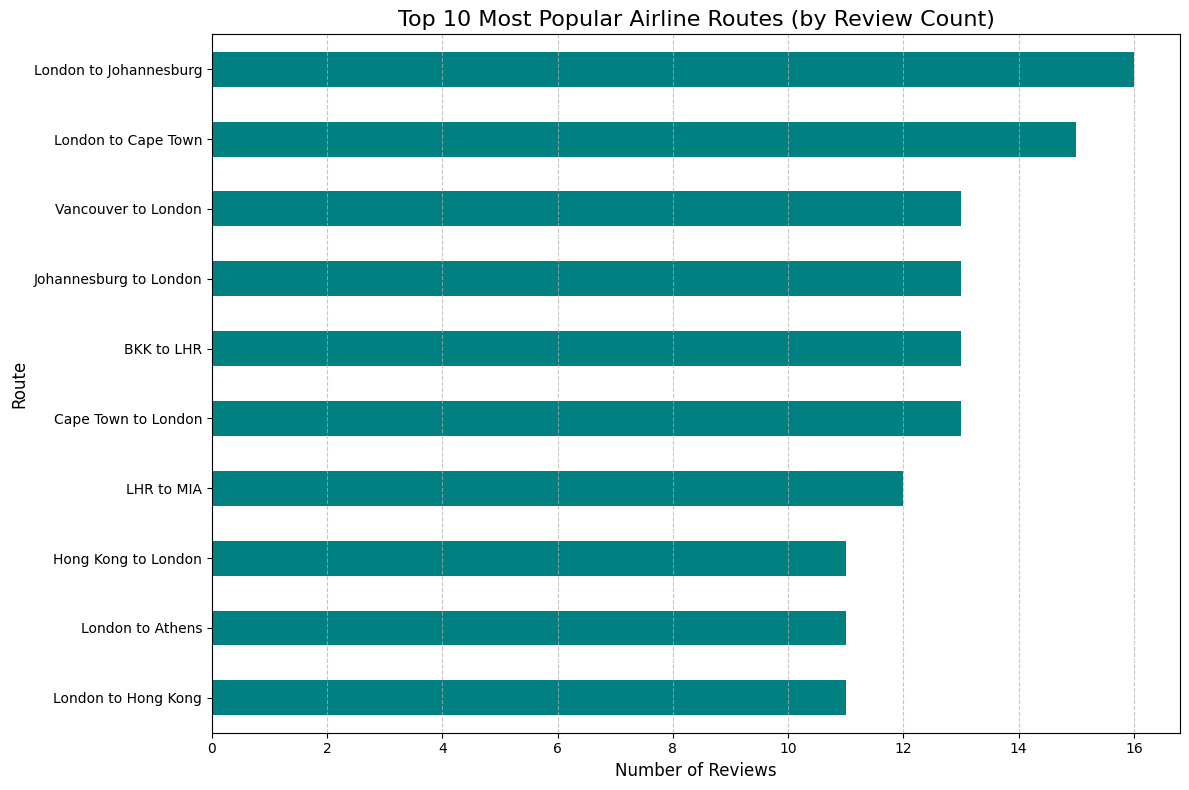

In [27]:
top_10_routes = AirlineScrappedReview['Route'].value_counts().head(10)
print("The most popular 10 routes are:" , top_10_routes)

plt.figure(figsize=(12, 8)) # Set a good size for readability
top_10_routes.sort_values(ascending=True).plot(kind='barh', color='teal')
plt.title('Top 10 Most Popular Airline Routes (by Review Count)', fontsize=16)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Route', fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.savefig('top_10_routes_barchart.png')
print("Saved bar chart to top_10_routes_barchart.png")

flight_hour
0     1539
1     2089
2     2642
3     2655
4     2843
5     2851
6     3051
7     3126
8     3165
9     3133
10    3085
11    3110
12    3163
13    3101
14    2833
15    2234
16    1557
17     861
18     439
19     295
20     276
21     389
22     579
23     986
Name: count, dtype: int64


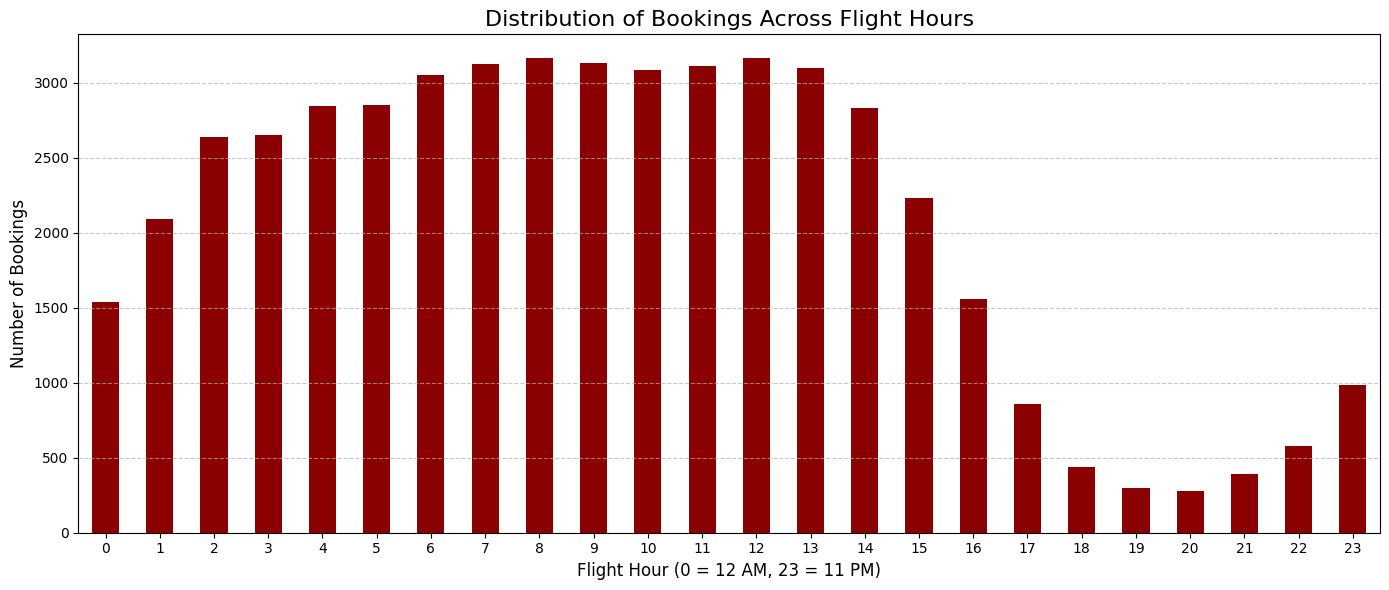

In [28]:
bookings_df = Passanger_Booking_Data

# 2. Calculate the number of completed bookings for each flight hour
hourly_bookings = bookings_df['flight_hour'].value_counts().sort_index()

plt.figure(figsize=(14, 6))

# Create a bar chart
hourly_bookings.plot(kind='bar', color='darkred') # Changed color for distinction

plt.title('Distribution of Bookings Across Flight Hours', fontsize=16)
plt.xlabel('Flight Hour (0 = 12 AM, 23 = 11 PM)', fontsize=12)
plt.ylabel('Number of Bookings', fontsize=12)
plt.xticks(rotation=0, ha='center') # Ensure hours are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot with a new name
plt.savefig('flight_hour_distribution.png')
print(hourly_bookings)

flight_hour
0     182
1     285
2     389
3     393
4     430
5     431
6     489
7     423
8     484
9     508
10    415
11    407
12    460
13    503
14    489
15    376
16    297
17    167
18     85
19     39
20     25
21     45
22     54
23    103
Name: count, dtype: int64


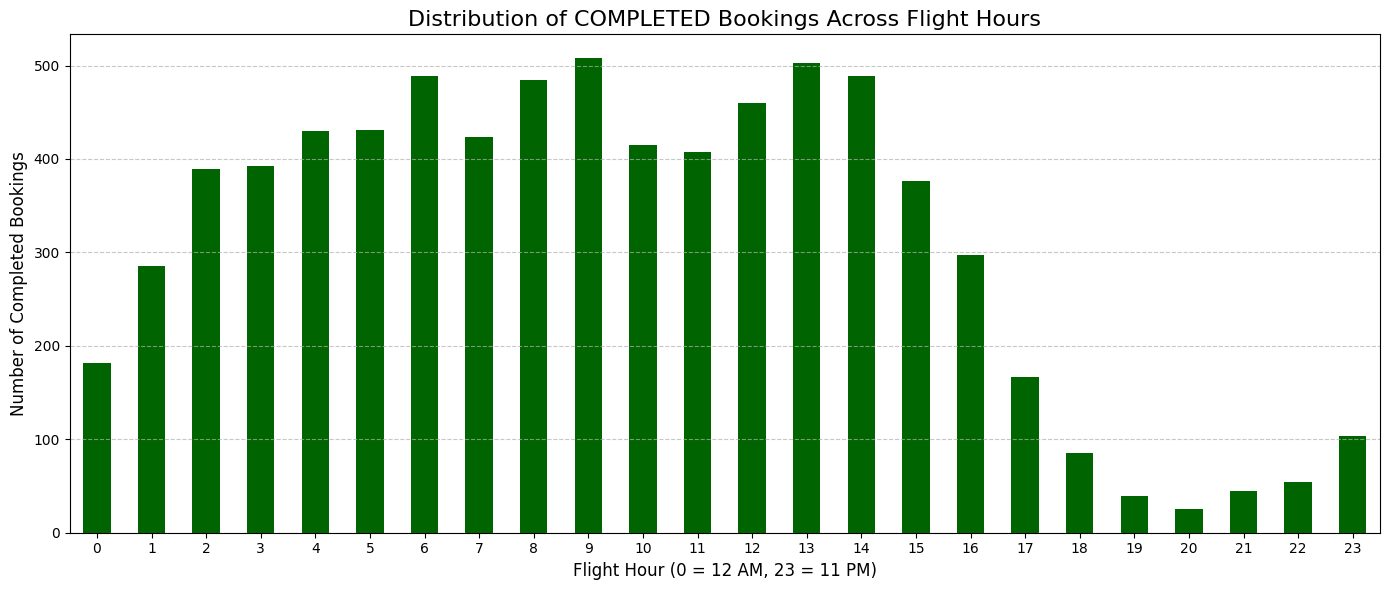

In [29]:
completed_bookings_df = Passanger_Booking_Data[Passanger_Booking_Data['booking_complete'] == 1]

hourly_bookings = completed_bookings_df['flight_hour'].value_counts().sort_index()

plt.figure(figsize=(14, 6))

hourly_bookings.plot(kind='bar', color='darkgreen') # Changed color for distinction

plt.title('Distribution of COMPLETED Bookings Across Flight Hours', fontsize=16)
plt.xlabel('Flight Hour (0 = 12 AM, 23 = 11 PM)', fontsize=12)
plt.ylabel('Number of Completed Bookings', fontsize=12)
plt.xticks(rotation=0, ha='center') # Ensure hours are readable
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the plot with a new name
plt.savefig('completed_flight_hour_distribution.png')
print(hourly_bookings)

In [30]:
combination_ratings = AirlineScrappedReview.groupby(['Traveller_Type', 'Class'])['Rating'].mean()

highest_rating_combo = combination_ratings.idxmax()
highest_rating_score = combination_ratings.max()

lowest_rating_combo = combination_ratings.idxmin()
lowest_rating_score = combination_ratings.min()

print("--- Traveler Type and Class Rating Analysis ---")
print("\n🏆 Highest Rated Combination:")
print(f"  Combination: {highest_rating_combo[0]} in {highest_rating_combo[1]}")
print(f"  Average Rating: {highest_rating_score:.3f}")

print("\n📉 Lowest Rated Combination:")
print(f"  Combination: {lowest_rating_combo[0]} in {lowest_rating_combo[1]}")
print(f"  Average Rating: {lowest_rating_score:.3f}")

--- Traveler Type and Class Rating Analysis ---

🏆 Highest Rated Combination:
  Combination: Solo Leisure in First Class
  Average Rating: 6.526

📉 Lowest Rated Combination:
  Combination: Various in Economy Class
  Average Rating: 1.000


PRE-PROCESSING & FEATURE ENGINEERING

In [31]:
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

In [32]:
AirlineScrappedReview['Verified'] = AirlineScrappedReview['Verified'].map({
    'Trip Verified': 1,
    'Not Verified': 0
})

AirlineScrappedReview = pd.get_dummies(AirlineScrappedReview,
                                       columns=['Traveller_Type', 'Class'],
                                       drop_first=True,
                                       dtype=int)

AirlineScrappedReview['is_layover'] = (AirlineScrappedReview['Layover_Route'] != 'None').astype(int)

AirlineScrappedReview['flight_distance_km'] = haversine(
    AirlineScrappedReview['Start_Latitude'],
    AirlineScrappedReview['Start_Longitude'],
    AirlineScrappedReview['End_Latitude'],
    AirlineScrappedReview['End_Longitude']
)

start_freq = AirlineScrappedReview['Start_Location'].map(AirlineScrappedReview['Start_Location'].value_counts())
end_freq = AirlineScrappedReview['End_Location'].map(AirlineScrappedReview['End_Location'].value_counts())
AirlineScrappedReview['start_loc_freq'] = start_freq
AirlineScrappedReview['end_loc_freq'] = end_freq

AirlineScrappedReview['start_country'] = AirlineScrappedReview['Start_Address'].apply(lambda x: x.split(',')[-1].strip())
AirlineScrappedReview['end_country'] = AirlineScrappedReview['End_Address'].apply(lambda x: x.split(',')[-1].strip())
AirlineScrappedReview['is_international'] = (AirlineScrappedReview['start_country'] != AirlineScrappedReview['end_country']).astype(int)

AirlineScrappedReview = AirlineScrappedReview.drop(['Start_Address', 'End_Address', 'Layover_Route', 'Start_Latitude', 'Start_Longitude', 'End_Latitude', 'End_Longitude', 'start_country', 'end_country', 'Review_content', 'Route'], axis=1)

SPLIT

In [33]:
X = AirlineScrappedReview.drop('Satisfaction', axis=1)
y = AirlineScrappedReview['Satisfaction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

FEATURE ENGINEERING

  FEATURE SET 1

In [34]:
X1_train = X_train.copy()
X1_test = X_test.copy()

numerical_cols_1 = ['Sentiment_Score', 'flight_distance_km', 'start_loc_freq', 'end_loc_freq']
scaler1 = StandardScaler()


X1_train[numerical_cols_1] = scaler1.fit_transform(X1_train[numerical_cols_1])

X1_test[numerical_cols_1] = scaler1.transform(X1_test[numerical_cols_1])

X1_train = X1_train.drop(['Start_Location', 'End_Location', 'Rating'], axis=1)
X1_test = X1_test.drop(['Start_Location', 'End_Location', 'Rating'], axis=1)

In [ ]:
#Task4 Recreate a heatmap of all numeric features.
numeric_df = X1_train.select_dtypes(include=['int64', 'float64'])


pivot = numeric_df.corr()


plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

FEATURE SET 2

In [35]:
X2_train = X_train.copy()
X2_test = X_test.copy()

start_loc_map = X2_train.groupby('Start_Location')['Rating'].mean()
end_loc_map = X2_train.groupby('End_Location')['Rating'].mean()

X2_train['Start_Loc_Avg_Rating'] = X2_train['Start_Location'].map(start_loc_map)
X2_train['End_Loc_Avg_Rating'] = X2_train['End_Location'].map(end_loc_map)

X2_test['Start_Loc_Avg_Rating'] = X2_test['Start_Location'].map(start_loc_map)
X2_test['End_Loc_Avg_Rating'] = X2_test['End_Location'].map(end_loc_map)

global_mean_rating = X2_train['Rating'].mean()
X2_test['Start_Loc_Avg_Rating'].fillna(global_mean_rating, inplace=True)
X2_test['End_Loc_Avg_Rating'].fillna(global_mean_rating, inplace=True)

X2_train = X2_train.drop(['start_loc_freq', 'end_loc_freq'], axis=1)
X2_test = X2_test.drop(['start_loc_freq', 'end_loc_freq'], axis=1)

numerical_cols_2 = ['Sentiment_Score', 'flight_distance_km', 'Start_Loc_Avg_Rating', 'End_Loc_Avg_Rating']
scaler2 = StandardScaler()


X2_train[numerical_cols_2] = scaler2.fit_transform(X2_train[numerical_cols_2])

X2_test[numerical_cols_2] = scaler2.transform(X2_test[numerical_cols_2])

X2_train = X2_train.drop(['Start_Location', 'End_Location', 'Rating'], axis=1)
X2_test = X2_test.drop(['Start_Location', 'End_Location', 'Rating'], axis=1)

/tmp/ipython-input-639414214.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X2_test['Start_Loc_Avg_Rating'].fillna(global_mean_rating, inplace=True)
/tmp/ipython-input-639414214.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

MODEL DEFINITIONS

In [36]:
# Models 1 & 3 use the Frequency Encoded dataset
model1 = Sequential([
    Input(shape=(X1_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

model3 = Sequential([
    Input(shape=(X1_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

# Model 2 uses the Target Encoded dataset
model2 = Sequential([
    Input(shape=(X2_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

print(f"X1_train shape: {X1_train.shape}")
print(f"X2_train shape: {X2_train.shape}")

X1_train shape: (2116, 14)
X2_train shape: (2116, 14)


In [37]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall')])

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall')])

model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',
                       Precision(name='precision'),
                       Recall(name='recall')])

In [38]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history1 = model1.fit(X1_train, y_train,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[early_stop])

history2 = model2.fit(X2_train, y_train,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[early_stop])

history3 = model3.fit(X1_train, y_train,
                      epochs=50,
                      validation_split=0.2,
                      verbose=1,
                      callbacks=[early_stop])

Epoch 1/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.4403 - loss: 0.7423 - precision: 0.4393 - recall: 0.9484 - val_accuracy: 0.5094 - val_loss: 0.6914 - val_precision: 0.4275 - val_recall: 0.6374
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6279 - loss: 0.6719 - precision: 0.5667 - recall: 0.6021 - val_accuracy: 0.6934 - val_loss: 0.6557 - val_precision: 0.6395 - val_recall: 0.5497
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7310 - loss: 0.6408 - precision: 0.6912 - recall: 0.6544 - val_accuracy: 0.7311 - val_loss: 0.6175 - val_precision: 0.6524 - val_recall: 0.7135
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7890 - loss: 0.5883 - precision: 0.7420 - recall: 0.8103 - val_accuracy: 0.7547 - val_loss: 0.5657 - val_precision: 0.6831 - val_recall: 0.7310
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7808 - loss: 0.5405 - precision: 0.7227 - recall: 0.8177 - val_accuracy: 0.7736 - val_loss: 0.5148 - va

Plotting history for Model 1...
Saved plot to model1_history.png
Plotting history for Model 2...
Saved plot to model2_history.png
Plotting history for Model 3...
Saved plot to model3_history.png


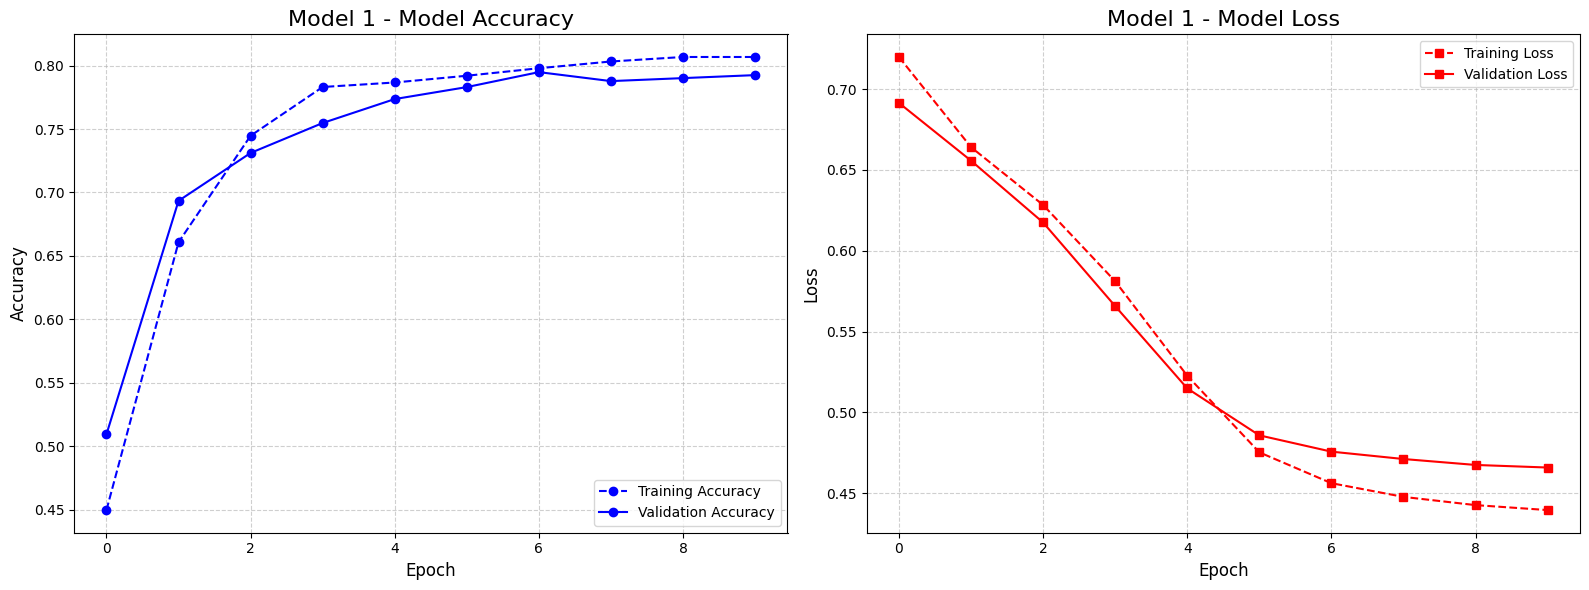

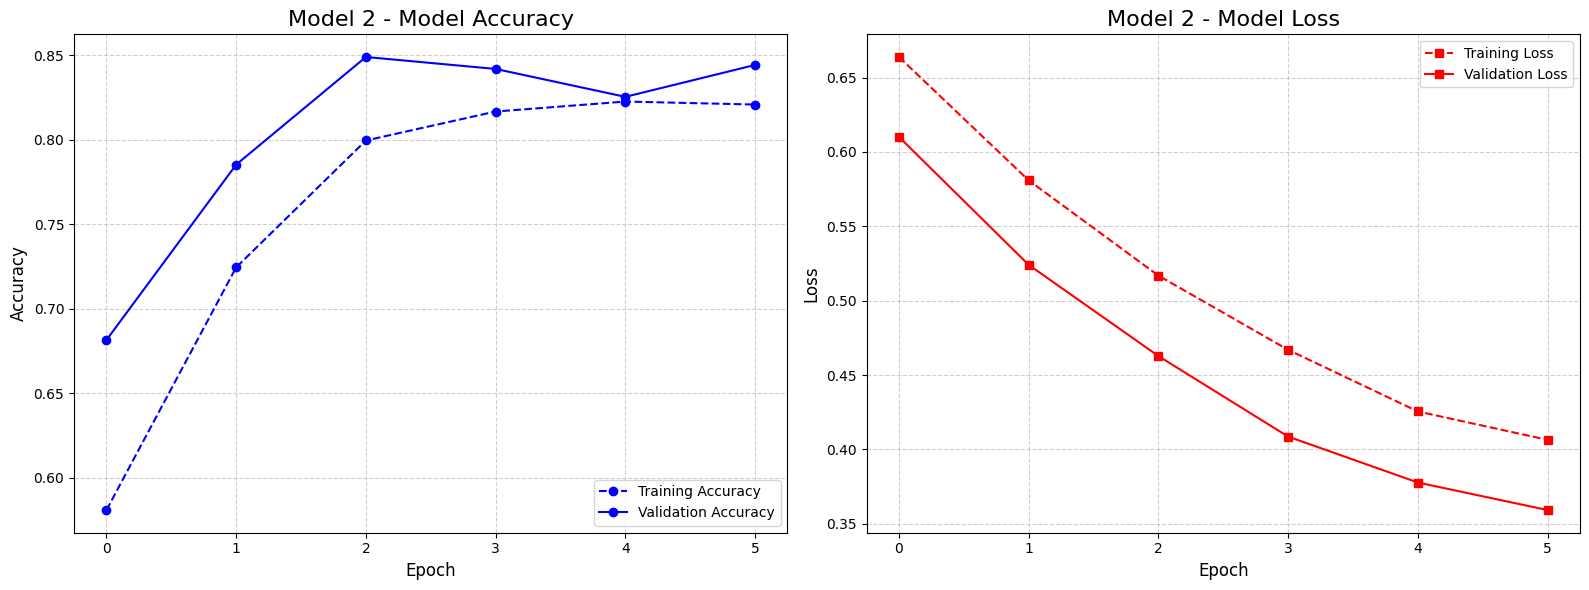

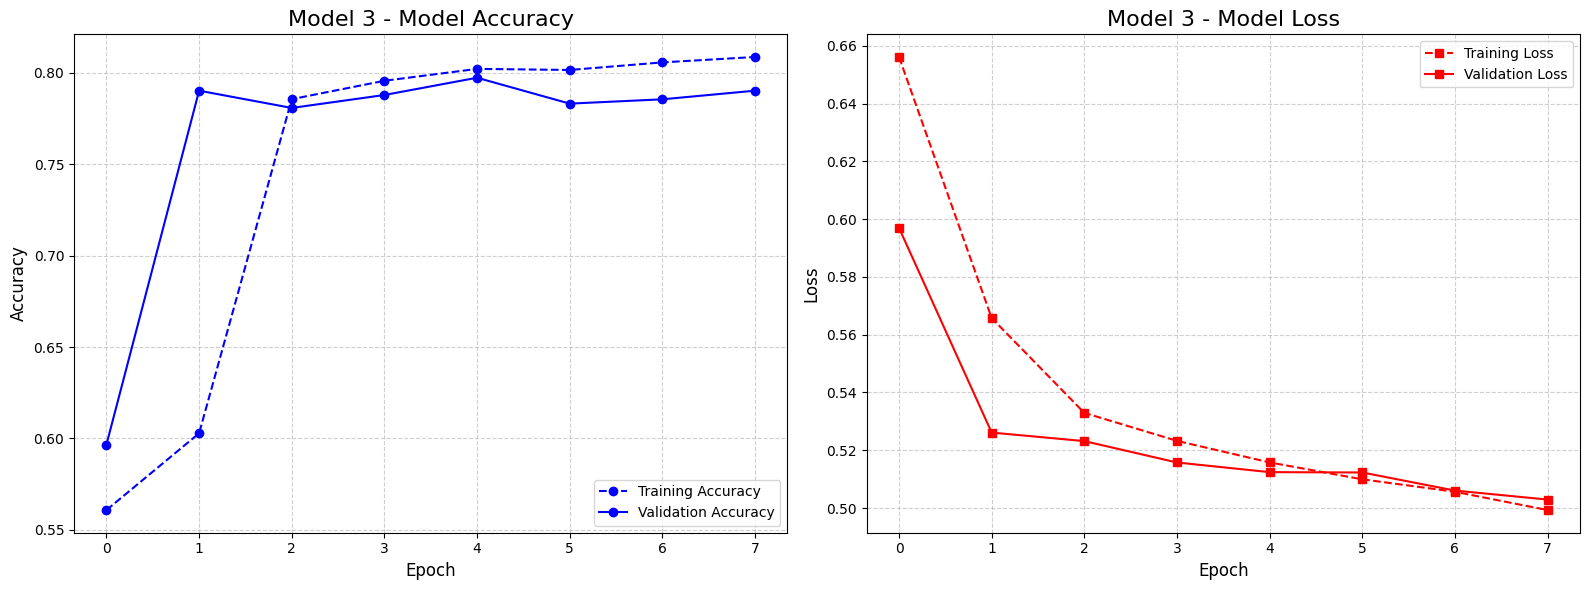

In [39]:
def plot_model_history(history, model_name, file_name):
    print(f"Plotting history for {model_name}...")

    # Create a figure with two subplots (side-by-side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot 1: Accuracy ---
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o', linestyle='--')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue', marker='o')
    ax1.set_title(f'{model_name} - Model Accuracy', fontsize=16)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.6)

    # --- Plot 2: Loss ---
    ax2.plot(history.history['loss'], label='Training Loss', color='red', marker='s', linestyle='--')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='s')
    ax2.set_title(f'{model_name} - Model Loss', fontsize=16)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(loc='upper right')
    ax2.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.savefig(file_name)
    print(f"Saved plot to {file_name}")

plot_model_history(history1, "Model 1", "model1_history.png")
plot_model_history(history2, "Model 2", "model2_history.png")
plot_model_history(history3, "Model 3", "model3_history.png")

Model Evaluations and Comparisons

In [40]:
metrics1 = model1.evaluate(X1_test, y_test, verbose=0)
y_pred1 = (model1.predict(X1_test, verbose=0) > 0.5).astype("int32")
f1_1 = f1_score(y_test, y_pred1)

metrics2 = model2.evaluate(X2_test, y_test, verbose=0)
y_pred2 = (model2.predict(X2_test, verbose=0) > 0.5).astype("int32")
f1_2 = f1_score(y_test, y_pred2)

metrics3 = model3.evaluate(X1_test, y_test, verbose=0)
y_pred3 = (model3.predict(X1_test, verbose=0) > 0.5).astype("int32")
f1_3 = f1_score(y_test, y_pred3)


results = {
    'Model': ['Model 1 (Freq Enc)', 'Model 2 (Target Enc)', 'Model 3 (Freq Enc, Deeper)'],
    'Test Loss': [metrics1[0], metrics2[0], metrics3[0]],
    'Accuracy': [metrics1[1], metrics2[1], metrics3[1]],
    'Precision': [metrics1[2], metrics2[2], metrics3[2]],
    'Recall': [metrics1[3], metrics2[3], metrics3[3]],
    'F1-Score': [f1_1, f1_2, f1_3]
}

df_results = pd.DataFrame(results)

print("--- Model Evaluation Results ---")
print(df_results.to_markdown(index=False))

--- Model Evaluation Results ---
| Model                      |   Test Loss |   Accuracy |   Precision |   Recall |   F1-Score |
|:---------------------------|------------:|-----------:|------------:|---------:|-----------:|
| Model 1 (Freq Enc)         |    0.451438 |   0.812854 |    0.781659 | 0.785088 |   0.78337  |
| Model 2 (Target Enc)       |    0.529738 |   0.773157 |    0.77     | 0.675439 |   0.719626 |
| Model 3 (Freq Enc, Deeper) |    0.509737 |   0.812854 |    0.781659 | 0.785088 |   0.78337  |


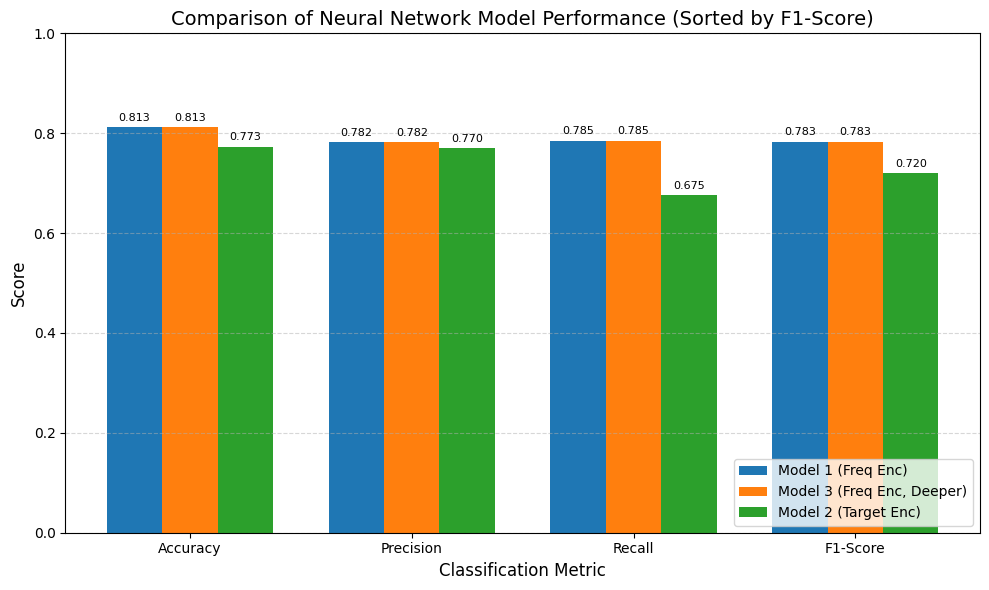

In [41]:
df_sorted = df_results.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

best_model = df_sorted.iloc[0]

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

plot_data = df_sorted.set_index('Model')[metrics_to_plot].T
models = plot_data.columns.tolist()

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(metrics_to_plot))

rects1 = ax.bar(index, plot_data[models[0]], bar_width, label=models[0], color='#1f77b4')
rects2 = ax.bar(index + bar_width, plot_data[models[1]], bar_width, label=models[1], color='#ff7f0e')
rects3 = ax.bar(index + 2*bar_width, plot_data[models[2]], bar_width, label=models[2], color='#2ca02c')

ax.set_ylabel('Score', fontsize=12)
ax.set_xlabel('Classification Metric', fontsize=12)
ax.set_title('Comparison of Neural Network Model Performance (Sorted by F1-Score)', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(metrics_to_plot)
ax.legend(loc='lower right')
ax.set_ylim(0, 1.0)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('model_comparison_f1_sorted_new.png')

Explainability

In [43]:
import shap
import lime
import lime.lime_tabular
import pandas as pd
import numpy as np

# --- 1. Define Our "Best" Model and Data ---
best_model = model1
X_train_processed = X1_train
X_test_processed = X1_test

print("--- 1. Setting up LIME ---")
# LIME Wrapper function
def lime_predict_fn(data_as_numpy):
    if data_as_numpy.ndim == 1:
        data_as_numpy = data_as_numpy.reshape(1, -1)
    prob_satisfied = best_model.predict(data_as_numpy, verbose=0)
    prob_dissatisfied = 1 - prob_satisfied
    return np.hstack([prob_dissatisfied, prob_satisfied])

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_processed.values,
    feature_names=X_train_processed.columns.tolist(),
    class_names=['Dissatisfied', 'Satisfied'],
    mode='classification',
    random_state=42
)
print("LIME Explainer created.")


print("\n--- 2. Setting up SHAP (using standard Explainer) ---")
shap.initjs()

background_data = shap.sample(X_train_processed, 100, random_state=42)

shap_explainer = shap.Explainer(best_model, background_data, feature_names=X_train_processed.columns)
print("SHAP Explainer (Kernel) created.")

print("\n--- 3. Calculating Global SHAP Values ---")
print(f"Calculating SHAP values for {X_test_processed.shape[0]} test samples.")
print("This will take several minutes. Please be patient...")

shap_values_test = shap_explainer(X_test_processed)

print("Global SHAP values (Explanation object) calculated for the test set.")

--- 1. Setting up LIME ---
LIME Explainer created.

--- 2. Setting up SHAP (using standard Explainer) ---


SHAP Explainer (Kernel) created.

--- 3. Calculating Global SHAP Values ---
Calculating SHAP values for 529 test samples.
This will take several minutes. Please be patient...


PermutationExplainer explainer: 530it [01:06,  6.72it/s]

Global SHAP values (Explanation object) calculated for the test set.


--- Global Feature Importance ---


/tmp/ipython-input-1545738721.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_test.values, X_test_processed)


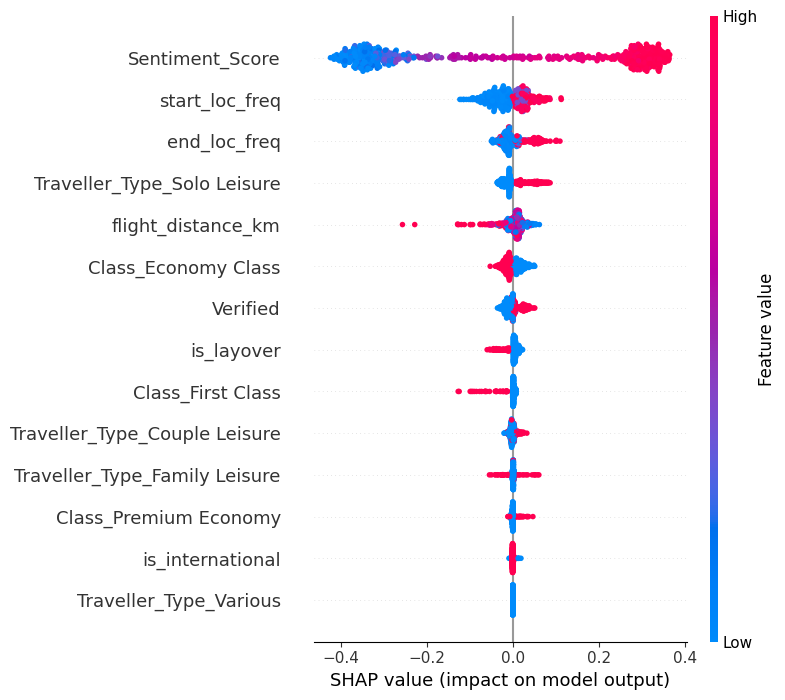

Sentiment_Score                  0.278928
start_loc_freq                   0.033710
end_loc_freq                     0.023073
Traveller_Type_Solo Leisure      0.022438
flight_distance_km               0.017787
Class_Economy Class              0.014709
Verified                         0.012221
is_layover                       0.008834
Class_First Class                0.005347
Traveller_Type_Couple Leisure    0.004866
Traveller_Type_Family Leisure    0.003442
Class_Premium Economy            0.002236
is_international                 0.000990
Traveller_Type_Various           0.000000
dtype: float64


In [62]:
print("--- Global Feature Importance ---")
shap.summary_plot(shap_values_test.values, X_test_processed)
shap_df = pd.DataFrame(shap_values_test.values, columns=X_train_processed.columns)
print(shap_df.abs().mean().sort_values(ascending=False))

In [61]:
print("\n--- Local Explanation: SHAP Force Plot ---")
shap.initjs()

instance_index = 10

instance_shap_explanation = shap_values_test[instance_index]
instance_features = X_test_processed.iloc[instance_index]

print(f"Explaining instance {instance_index}")
print(f"Model Prediction: {pred_label} (Confidence: {pred_prob:.2%})") # Uses pred_label from LIME cell

base_value = instance_shap_explanation.base_values
if isinstance(base_value, np.ndarray):
    base_value = base_value[0] # Select first (only) output

print(f"SHAP Base Value: {base_value:.4f}")
shap.force_plot(
    base_value=base_value,
    shap_values=instance_shap_explanation.values,
    features=instance_features.values,
    feature_names=X_test_processed.columns.tolist()
)


--- Local Explanation: SHAP Force Plot ---


Explaining instance 10
Model Prediction: Dissatisfied (Confidence: 12.92%)
SHAP Base Value: 0.4392


In [64]:
print("\n--- Local Explanation: LIME ---")

# --- 1. Define the instance we're explaining ---
instance_index = 10
instance_to_explain_lime = X_test_processed.iloc[instance_index]

print(f"Explaining instance {instance_index}")

# --- 2. Get Model Prediction ---
pred_prob = best_model.predict(instance_to_explain_lime.values.reshape(1, -1), verbose=0)[0][0]
pred_label = "Satisfied" if pred_prob > 0.5 else "Dissatisfied"
print(f"Model Prediction: {pred_label} (Confidence: {pred_prob:.2%})")

# --- 3. Generate and Show LIME Explanation ---
lime_explanation = lime_explainer.explain_instance(
    data_row=instance_to_explain_lime.values,
    predict_fn=lime_predict_fn,
    num_features=10, # Show top 10 features
    top_labels=1 # Only show explanation for the top-predicted class
)

print("\nLIME Explanation:")
lime_explanation.show_in_notebook(show_table=True)


--- Local Explanation: LIME ---
Explaining instance 10
Model Prediction: Dissatisfied (Confidence: 12.92%)

LIME Explanation:


INFERENCE

In [69]:
def predict_satisfaction(raw_input: dict):
    features_df = pd.DataFrame(columns=X1_train.columns.tolist(), index=[0]).fillna(0)

    features_df['Sentiment_Score'] = sia.polarity_scores(raw_input.get('Review_content', ''))['compound']

    features_df['Verified'] = 1 if raw_input.get('Verified') == 'Trip Verified' else 0

    layover = raw_input.get('Layover_Route') or "None" # Handle None/NaN
    features_df['is_layover'] = 1 if layover != "None" else 0

    features_df['flight_distance_km'] = haversine(
            raw_input['Start_Latitude'], raw_input['Start_Longitude'],
            raw_input['End_Latitude'], raw_input['End_Longitude'])

    features_df['start_loc_freq'] = (AirlineScrappedReview['Start_Location'].value_counts().to_dict()).get(raw_input.get('Start_Location'), 0)
    features_df['end_loc_freq'] = (AirlineScrappedReview['End_Location'].value_counts().to_dict()).get(raw_input.get('End_Location'), 0)

    start_country = raw_input.get('Start_Address', '').split(',')[-1].strip()
    end_country = raw_input.get('End_Address', '').split(',')[-1].strip()
    features_df['is_international'] = 1 if (start_country != end_country and start_country != '') else 0

    tt_col = f"Traveller_Type_{raw_input.get('Traveller_Type')}"
    if tt_col in features_df.columns:
        features_df[tt_col] = 1

    class_col = f"Class_{raw_input.get('Class')}"
    if class_col in features_df.columns:
        features_df[class_col] = 1

    numerical_cols = ['Sentiment_Score', 'flight_distance_km', 'start_loc_freq', 'end_loc_freq']
    features_df[numerical_cols] = scaler1.transform(features_df[numerical_cols])

    probability = model1.predict(features_df)[0][0]
    prediction = 1 if probability >= 0.5 else 0

    # --- 6. Return Natural Language Output ---
    satisfaction_label = "Satisfied" if prediction == 1 else "Dissatisfied"
    confidence = probability if prediction == 1 else 1 - probability

    return f"Prediction: {satisfaction_label} (Confidence: {confidence:.2%})"

In [70]:
# Scenario 1: Dissatisfied
scenario_1_dissatisfied = {
    "Verified": "Trip Verified",
    "Review_content": "This was, without a doubt, the worst long-haul flight of my life. The nightmare began at check-in where the staff were rude and unhelpful. The flight from Chicago was delayed by 3 hours with no explanation. This meant I had to sprint through LAX to make my connection, which they barely held. Once on board, my seat was cramped and the entertainment screen was broken. The food was a tasteless, lukewarm mush. To top it all off, when I finally arrived in Tokyo, my luggage was lost. It's been 48 hours and I still have no update. An absolutely abysmal experience from start to finish.",
    "Traveller_Type": "Solo Leisure",
    "Class": "Economy Class",
    "Start_Location": "Chicago",
    "End_Location": "Tokyo",
    "Layover_Route": "LAX",
    "Start_Latitude": 41.9769,
    "Start_Longitude": -87.9081,
    "Start_Address": "10000 W O'Hare Ave, Chicago, IL 60666, United States",
    "End_Latitude": 35.7647,
    "End_Longitude": 140.386,
    "End_Address": "1-1 Furugome, Narita, Chiba 282-0004, Japan"
}

# Scenario 2: Satisfied
scenario_2_satisfied = {
    "Verified": "Trip Verified",
    "Review_content": "A truly flawless journey from London to Dubai. Boarding was prioritized and incredibly efficient. From the moment I stepped on board, the cabin crew was attentive, professional, and genuinely welcoming, offering a glass of champagne right away. The lie-flat bed in business class was extremely comfortable, and the amenity kit was well-stocked. The three-course meal was restaurant-quality, and the wine selection was excellent. We arrived in Dubai 20 minutes ahead of schedule, and my bags were one of the first off the carousel. This is how flying should be. Highly recommended.",
    "Traveller_Type": "Couple Leisure",
    "Class": "Business Class",
    "Start_Location": "London",
    "End_Location": "Dubai",
    "Layover_Route": np.nan, # Or "None", the function handles both
    "Start_Latitude": 51.4706,
    "Start_Longitude": -0.4619,
    "Start_Address": "Heathrow Airport, Hounslow, Middlesex, TW6 1EW, United Kingdom",
    "End_Latitude": 25.2531,
    "End_Longitude": 55.3644,
    "End_Address": "Dubai International Airport, Al Garhoud, Dubai, United Arab Emirates"
}


# --- Run the function ---
print("--- Running Inference ---")

# Test Example 1
prediction_1 = predict_satisfaction(scenario_1_dissatisfied)
print(f"Example 1 Input (Chicago to Tokyo):\n {prediction_1}")

# Test Example 2
prediction_2 = predict_satisfaction(scenario_2_satisfied)
print(f"Example 2 Input (London to Dubai):\n {prediction_2}")

--- Running Inference ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Example 1 Input (Chicago to Tokyo):
 Prediction: Dissatisfied (Confidence: 91.30%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Example 2 Input (London to Dubai):
 Prediction: Satisfied (Confidence: 84.43%)


/tmp/ipython-input-668810383.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = pd.DataFrame(columns=X1_train.columns.tolist(), index=[0]).fillna(0)
/tmp/ipython-input-668810383.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features_df = pd.DataFrame(columns=X1_train.columns.tolist(), index=[0]).fillna(0)
